In [1]:
print("test")

test


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
import os
from oggm.core import inversion
from oggm import cfg,tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import salem
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
cfg.PATHS['working_dir'] = '/mnt/d/lidar/ali/area/same_boundary'


2025-09-17 18:10:38: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-09-17 18:10:38: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-09-17 18:10:38: oggm.cfg: Multiprocessing: using all available processors (N=24)
2025-09-17 18:10:39: oggm.utils: Failed getting verification checksum: ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'cluster.klima.uni-bremen.de\', port=443): Max retries exceeded with url: /data/downloads.sha256.hdf.sha256 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f4981ebba10>: Failed to resolve \'cluster.klima.uni-bremen.de\' ([Errno -3] Temporary failure in name resolution)"))'))
2025-09-17 18:10:39: oggm.cfg: Multiprocessing switched ON after user settings.
2025-09-17 18:10:39: oggm.cfg: Multiprocessing: using the requested number of processors (N=12)


In [3]:
# Set-up the run
cfg.PARAMS['border'] = 10

# We don't use intersects here
cfg.PARAMS['use_intersects'] = False

# We prefer OGGM to use the area we computed ourselves
cfg.PARAMS['use_rgi_area'] = True

# Use our merged file
rgidf = gpd.read_file('/mnt/d/lidar/ali/area/same_boundary/aru50_af.shp')


gdirs = workflow.init_glacier_directories(rgidf,reset=True, force=True)
gdirs

2025-09-17 18:10:39: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-09-17 18:10:39: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2025-09-17 18:10:39: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


[<oggm.GlacierDirectory>
   RGI id: RGI60-13.51476_2
   Region: 13: Central Asia
   Subregion: 13-08: Inner Tibet                     
   Name: Aru50_Af
   Glacier type: Ice cap
   Terminus type: Land-terminating
   Status: Glacier or ice cap
   Area: 4.647 km2
   Lon, Lat: (82.26475104493404, 34.003365093944694)]

In [4]:
## 输出tasks中的函数名
import oggm.tasks as tasks
print(dir(tasks))


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'apparent_mb_from_any_mb', 'apparent_mb_from_linear_mb', 'catchment_area', 'catchment_intersections', 'catchment_width_correction', 'catchment_width_geom', 'compute_centerlines', 'compute_downstream_bedshape', 'compute_downstream_line', 'compute_ela', 'compute_hypsometry_attributes', 'compute_inversion_velocities', 'compute_velocities', 'copy_to_basedir', 'define_glacier_region', 'distribute_thickness_interp', 'distribute_thickness_per_altitude', 'elevation_band_flowline', 'filter_inversion_output', 'find_inversion_calving_from_any_mb', 'fixed_dx_elevation_band_flowline', 'fixed_geometry_mass_balance', 'flowline_model_run', 'gdir_to_tar', 'get_inversion_volume', 'glacier_masks', 'gridded_attributes', 'gridded_data_var_to_geotiff', 'gridded_mb_attributes', 'historical_delta_method', 'init_present_time_glacier', 'initialize_flowlines', 'mass_conservation_inversion', 'mb_calibration_

In [9]:
# 1. 计算中心线和 catchment 属性


workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source = 'SRTM',reset=True)
workflow.execute_entity_task(tasks.glacier_masks, gdirs, reset=True)
workflow.execute_entity_task(tasks.compute_centerlines, gdirs)
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs)
workflow.execute_entity_task(tasks.catchment_area, gdirs)
workflow.execute_entity_task(tasks.catchment_intersections, gdirs)
workflow.execute_entity_task(tasks.catchment_width_geom, gdirs)
workflow.execute_entity_task(tasks.catchment_width_correction, gdirs)




# # 2. Mass balance 的准备：先计算 mu*（请根据 OGGM 版本选用）

workflow.execute_entity_task(tasks.process_climate_data, gdirs)
# workflow.execute_entity_task(tasks.apparent_mb_from_climate, gdirs)

# workflow.execute_entity_task(tasks.process_climate_data, gdirs)

# workflow.execute_entity_task(tasks.mb_calibration_from_geodetic_mb, gdirs[0])

# workflow.execute_entity_task(tasks.apparent_mb_from_any_mb, gdirs)

# workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)


# workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs)

# （可选）5. 用平衡线方法进行反演（作为比较）

# workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)
# workflow.execute_entity_task(tasks.compute_dowstream_line, gdirs)
# workflow.execute_entity_task(tasks.filter_inversion_output, gdirs)



# # 3. 计算 inversion 输入（流线上的厚度/坡度等）
# workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)

# # 4. 冰川体积反演（厚度估计）
# workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs)
# workflow.execute_entity_task(tasks.filter_inversion_output, gdirs)

# # ✅ 5. 关键步骤：初始化现代冰川模型（这一步会生成 `model_flowlines.pkl`）
# workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


2025-09-17 18:12:00: oggm.workflow: Execute entity tasks [define_glacier_region] on 1 glaciers
2025-09-17 18:12:00: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2025-09-17 18:12:00: oggm.workflow: Execute entity tasks [compute_centerlines] on 1 glaciers
2025-09-17 18:12:00: oggm.workflow: Execute entity tasks [initialize_flowlines] on 1 glaciers
2025-09-17 18:12:00: oggm.workflow: Execute entity tasks [catchment_area] on 1 glaciers
2025-09-17 18:12:00: oggm.workflow: Execute entity tasks [catchment_intersections] on 1 glaciers
2025-09-17 18:12:01: oggm.workflow: Execute entity tasks [catchment_width_geom] on 1 glaciers
2025-09-17 18:12:01: oggm.workflow: Execute entity tasks [catchment_width_correction] on 1 glaciers
2025-09-17 18:12:01: oggm.workflow: Execute entity tasks [process_climate_data] on 1 glaciers


[None]

In [ ]:
gdirs[0].get_climate_info()

In [ ]:
# Do a random run with a bit of warming
workflow.execute_entity_task(
    tasks.run_random_climate,
    gdirs,
    ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
    y0=2009, halfsize=10,  # Random climate of 1999-2019
    seed=1,  # Random number generator seed 
    temperature_bias=1.5,  # additional warming - change for other scenarios
    store_fl_diagnostics=True,  # important! This will be needed for the redistribution
    init_model_filesuffix='_spinup_historical',  # start from the spinup run
    output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
);

####################################################################
############# 注意执行完这部后出现baseline source 的错误再执行一下上上面的
###################################################################

2025-09-17 18:15:46: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers


In [24]:
from oggm.sandbox import distribute_2d
from functools import partial
from oggm.core.massbalance import MonthlyTIModel
# 记录成功的 glacier
# good_gdirs = []

# for gdir in gdirs:
#     try:
#         distribute_2d.assign_points_to_band(gdir)
#         good_gdirs.append(gdir)
#     except AssertionError as e:
#         print(f"❌ Skipping {gdir.rgi_id}: AssertionError - {e}")
#     except Exception as e:
#         print(f"⚠️ Skipping {gdir.rgi_id}: Unexpected Error - {e}")

# This is to add a new topography to the file (smoothed differently)
workflow.execute_entity_task(distribute_2d.add_smoothed_glacier_topo, gdirs)
# This is to get the bed map at the start of the simulation
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
workflow.execute_entity_task(distribute_2d.assign_points_to_band, gdirs);
cfg.PARAMS['baseline_climate'] = 'ERA5L-HMA'
# 主要的地形和流线建模任务
workflow.execute_entity_task(tasks.glacier_masks, gdirs)
workflow.execute_entity_task(tasks.compute_centerlines, gdirs)
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs)
workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
# workflow.execute_entity_task(tasks.compute_inversion_tasks, gdirs)
# workflow.execute_entity_task(tasks.inversion_concatenation, gdirs)
# workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)

# 🔧 加上这个气候处理步骤（必须！）
workflow.execute_entity_task(tasks.process_ecmwf_data, gdirs)
# workflow.execute_entity_task(tasks.process_cru_data, gdirs)

# 最后执行你的模拟
workflow.execute_entity_task(
    tasks.run_constant_climate,
    gdirs,
    ys=2020, ye=2240,
    y0=2009, halfsize=10,

    temperature_bias=1.5,
    store_fl_diagnostics=True,
    init_model_filesuffix='_spinup_historical',
    output_filesuffix='_random_s1',
    mb_model_class=partial(MonthlyTIModel, check_calib_params=False)
)

2025-09-17 18:15:46: oggm.workflow: Execute entity tasks [add_smoothed_glacier_topo] on 1 glaciers
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [assign_points_to_band] on 1 glaciers
2025-09-17 18:15:47: oggm.cfg: PARAMS['baseline_climate'] changed from `GSWP3_W5E5` to `ERA5L-HMA`.
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [compute_centerlines] on 1 glaciers
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [initialize_flowlines] on 1 glaciers
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [compute_downstream_line] on 1 glaciers
2025-09-17 18:15:47: oggm.workflow: Execute entity tasks [process_ecmwf_data] on 1 glaciers
2025-09-17 18:15:49: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers


In [11]:
from oggm.sandbox import distribute_2d
# This is to add a new topography to the file (smoothed differently)
workflow.execute_entity_task(distribute_2d.add_smoothed_glacier_topo, gdirs)
# This is to get the bed map at the start of the simulation
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
workflow.execute_entity_task(distribute_2d.assign_points_to_band, gdirs);

2025-09-17 18:12:54: oggm.workflow: Execute entity tasks [add_smoothed_glacier_topo] on 1 glaciers
2025-09-17 18:12:54: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-09-17 18:12:55: oggm.workflow: Execute entity tasks [assign_points_to_band] on 1 glaciers


In [12]:
gdir = gdirs[0]  # here for Aletsch
#gdir = gdirs[1]  # uncomment for Fieschergletscher

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

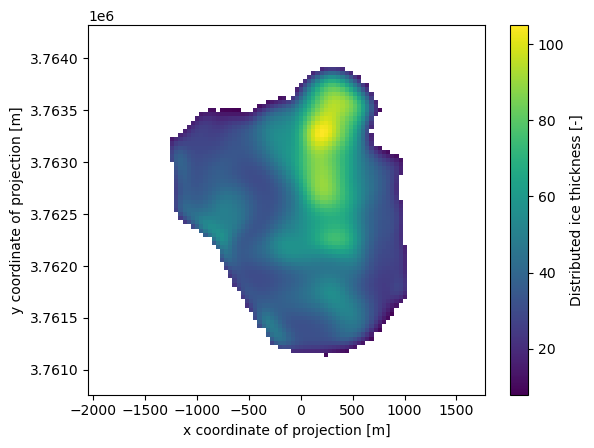

In [13]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

In [14]:
ds = workflow.execute_entity_task(
    distribute_2d.distribute_thickness_from_simulation,
    gdirs,
    input_filesuffix='_random_s1',
    concat_input_filesuffix='_spinup_historical',
    output_filesuffix='',
)


2025-09-17 18:13:02: oggm.workflow: Execute entity tasks [distribute_thickness_from_simulation] on 1 glaciers


In [266]:
rm /mnt/d/lidar/ali/area/same_boundary/per_glacier/RGI60-13.5/RGI60-13.5147/RGI60-13.51476_1/gridded_data.nc


In [57]:
from oggm.sandbox import distribute_2d

In [58]:
# This is to add a new topography to the file (smoothed differently)
# workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs)


# 2. 处理DEM，生成 gridded_data.nc
workflow.execute_entity_task(tasks.process_dem, gdirs)
workflow.execute_entity_task(tasks.glacier_masks,gdirs)
workflow.execute_entity_task(distribute_2d.add_smoothed_glacier_topo, gdirs)
# This is to get the bed map at the start of the simulation
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
workflow.execute_entity_task(distribute_2d.assign_points_to_band, gdirs);

2025-09-17 12:21:02: oggm.workflow: Execute entity tasks [process_dem] on 1 glaciers
2025-09-17 12:21:02: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2025-09-17 12:21:02: oggm.workflow: Execute entity tasks [add_smoothed_glacier_topo] on 1 glaciers
2025-09-17 12:21:02: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-09-17 12:21:02: oggm.core.inversion: IndexError occurred during task distribute_thickness_per_altitude on RGI60-13.51476_2: index 30 is out of bounds for axis 0 with size 30


IndexError: index 30 is out of bounds for axis 0 with size 30

In [59]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import salem
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
gdir = gdirs[0]  # here for Aletsch
#gdir = gdirs[1]  # uncomment for Fieschergletscher

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

In [60]:
from oggm.sandbox import distribute_2d

ds = workflow.execute_entity_task(
    distribute_2d.distribute_thickness_from_simulation,
    gdirs,
    input_filesuffix='_random_s1',
    concat_input_filesuffix='_spinup_historical',
    output_filesuffix='',
)

2025-09-17 12:21:09: oggm.workflow: Execute entity tasks [distribute_thickness_from_simulation] on 1 glaciers
2025-09-17 12:21:09: oggm.sandbox.distribute_2d: FileNotFoundError occurred during task distribute_thickness_from_simulation on RGI60-13.51476_2: [Errno 2] No such file or directory: '/mnt/d/lidar/ali/area/same_boundary/per_glacier/RGI60-13.5/RGI60-13.5147/RGI60-13.51476_2/fl_diagnostics_random_s1.nc'


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/lidar/ali/area/same_boundary/per_glacier/RGI60-13.5/RGI60-13.5147/RGI60-13.51476_2/fl_diagnostics_random_s1.nc'

In [61]:
def plot_distributed_thickness(ds, title):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ds.simulated_thickness.sel(time=2005).plot(ax=ax1, vmax=150);
    ds.simulated_thickness.sel(time=2050).plot(ax=ax2, vmax=150);
    ds.simulated_thickness.sel(time=2100).plot(ax=ax3, vmax=150);
    ax1.axis('equal'); ax2.axis('equal'); f.suptitle(title, fontsize=20);
    plt.tight_layout();

plot_distributed_thickness(ds[0], 'A')

KeyError: "No variable named 0. Variables on the dataset include ['x', 'y', 'topo', 'topo_smoothed', 'topo_valid_mask', ..., 'ice_divides', 'slope', 'aspect', 'slope_factor', 'dis_from_border']"

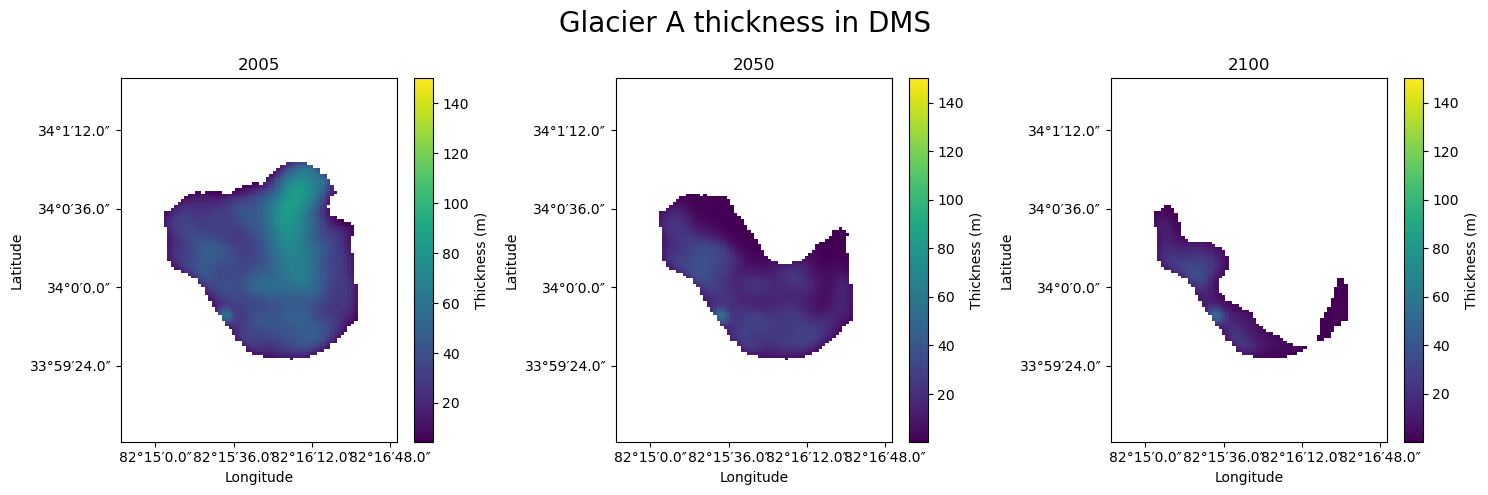

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pyproj
import xarray as xr

def deg2dms(x, pos):
    # x 是度小数，pos 是位置参数
    degrees = int(x)
    minutes = int(abs(x - degrees) * 60)
    seconds = (abs(x - degrees) * 60 - minutes) * 60
    return f"{degrees}°{minutes}′{seconds:.1f}″"

def plot_distributed_thickness(ds, title):
    # 坐标网格
    x = ds.coords['x'].values
    y = ds.coords['y'].values
    xx, yy = np.meshgrid(x, y)

    # 获取投影信息
    proj = pyproj.CRS.from_string(ds.attrs['pyproj_srs'])
    wgs84 = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(proj, wgs84, always_xy=True)

    # 转换为经纬度
    lon, lat = transformer.transform(xx, yy)

    # 准备图像
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    times = [2005, 2050, 2100]

    for i, t in enumerate(times):
        im = axes[i].pcolormesh(lon, lat, ds.simulated_thickness.sel(time=t), shading='auto', cmap='viridis', vmax=150)
        axes[i].set_title(f"{t}")
        axes[i].axis('equal')
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(deg2dms))
        axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(deg2dms))
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[i], orientation='vertical', label='Thickness (m)')

    fig.suptitle(title, fontsize=20)
    fig.savefig('/mnt/d/lidar/ali/area/same_boundary/glacier_thickness_dms.eps', format='eps')
    plt.tight_layout()
    plt.show()

# 使用方式
plot_distributed_thickness(ds[0], 'Glacier A thickness in DMS')


In [44]:
import contextily as ctx

print(list(ctx.providers.keys()))


['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey', 'UN']


ConnectionError: HTTPSConnectionPool(host='a.tile.opentopomap.org', port=443): Max retries exceeded with url: /14/11934/6543.png (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f4975644e50>: Failed to resolve 'a.tile.opentopomap.org' ([Errno -3] Temporary failure in name resolution)"))

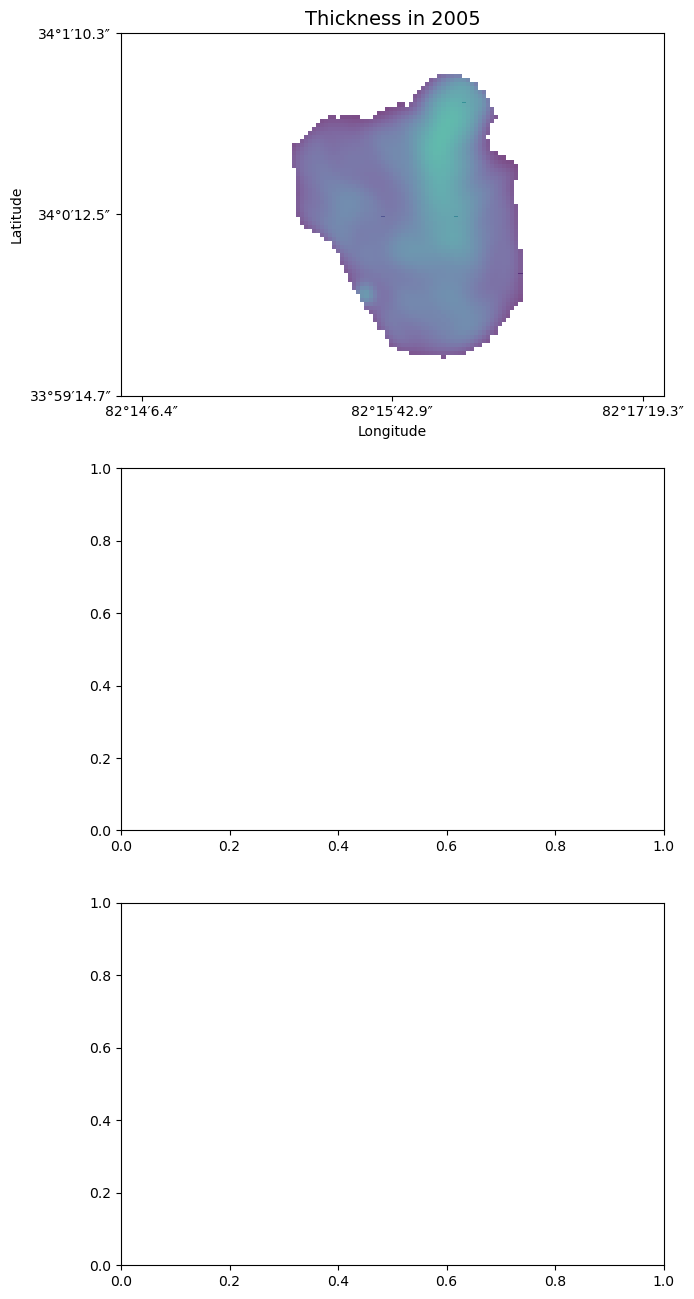

In [16]:
def plot_distributed_thickness_with_basemap(ds, title):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import numpy as np
    import pyproj
    import contextily as ctx

    def get_grid_edges(arr):
        edges = (arr[:-1] + arr[1:]) / 2
        edges = np.concatenate(([arr[0] - (edges[0] - arr[0])], edges, [arr[-1] + (arr[-1] - edges[-1])]))
        return edges

    def deg2dms(x, pos):
        degrees = int(x)
        minutes = int(abs(x - degrees) * 60)
        seconds = (abs(x - degrees) * 60 - minutes) * 60
        return f"{degrees}°{minutes}′{seconds:.1f}″"

    # 原始中心坐标
    x = ds.coords['x'].values
    y = ds.coords['y'].values

    # 获取边界点（适用于pcolormesh）
    x_edges = get_grid_edges(x)
    y_edges = get_grid_edges(y)
    xx_edges, yy_edges = np.meshgrid(x_edges, y_edges)

    # 坐标变换器：原始 → Web Mercator（用于底图）
    proj = pyproj.CRS.from_string(ds.attrs['pyproj_srs'])
    web_mercator = pyproj.CRS.from_epsg(3857)
    transformer_to_wm = pyproj.Transformer.from_crs(proj, web_mercator, always_xy=True)
    wm_x, wm_y = transformer_to_wm.transform(xx_edges, yy_edges)

    # 再从 Web Mercator → 经纬度（用于坐标刻度标签）
    transformer_to_wgs84 = pyproj.Transformer.from_crs(web_mercator, 4326, always_xy=True)
    lon, lat = transformer_to_wgs84.transform(wm_x, wm_y)

    fig, axes = plt.subplots(3, 1, figsize=(7, 16))
    times = [2005, 2050, 2100]

    for i, t in enumerate(times):
        ax = axes[i]

        

        # 厚度图层
        im = ax.pcolormesh(wm_x, wm_y,
                           ds.simulated_thickness.sel(time=t),
                           shading='auto', cmap='viridis', vmax=150, alpha=0.7)

        # 设置坐标轴范围
        ax.set_xlim(wm_x.min(), wm_x.max())
        ax.set_ylim(wm_y.min(), wm_y.max())
        ax.set_title(f"Thickness in {t}", fontsize=14)
        ax.axis('equal')

        # 设置坐标刻度为经纬度
        
        xticks = np.linspace(wm_x.min()-1300, wm_x.max()+1000, 3)
        yticks = np.linspace(wm_y.min(), wm_y.max(), 3)
        lon_ticks, lat_ticks = transformer_to_wgs84.transform(xticks, yticks)

        ax.set_xticks(xticks)
        ax.set_yticks(yticks)

        ax.xaxis.set_major_formatter(mticker.FuncFormatter(
            lambda x, pos: deg2dms(transformer_to_wgs84.transform(x, wm_y.mean())[0], pos)))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(
            lambda y, pos: deg2dms(transformer_to_wgs84.transform(wm_x.mean(), y)[1], pos)))

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
# 显示底图
        ctx.add_basemap(ax, crs=web_mercator, source="OpenTopoMap")

        fig.colorbar(im, ax=ax, orientation='vertical', label='Thickness (m)')
   
    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()
plot_distributed_thickness_with_basemap(ds[0], 'Aru50 Thickness with Basemap')

ConnectionError: HTTPSConnectionPool(host='a.tile.opentopomap.org', port=443): Max retries exceeded with url: /10/745/408.png (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f496f151850>: Failed to resolve 'a.tile.opentopomap.org' ([Errno -3] Temporary failure in name resolution)"))

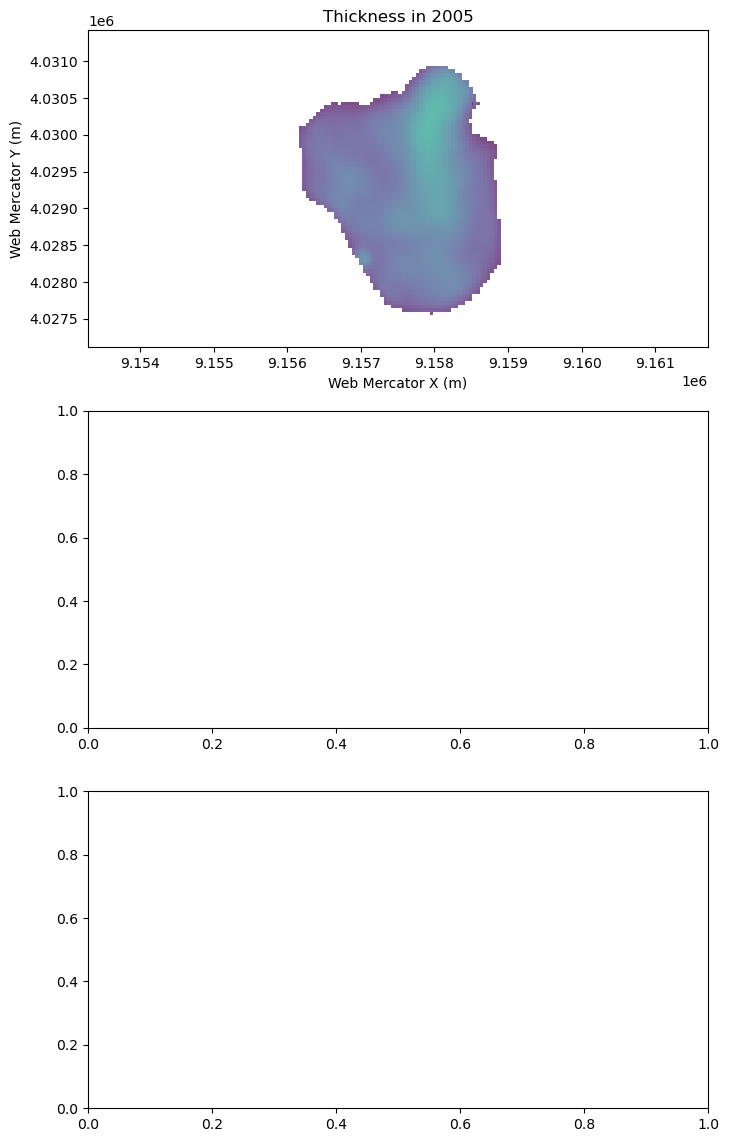

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pyproj
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box

def deg2dms(x, pos):
    degrees = int(x)
    minutes = int(abs(x - degrees) * 60)
    seconds = (abs(x - degrees) * 60 - minutes) * 60
    return f"{degrees}°{minutes}′{seconds:.1f}″"

def plot_distributed_thickness_with_basemap(ds, title):
    x = ds.coords['x'].values
    y = ds.coords['y'].values
    xx, yy = np.meshgrid(x, y)

    # 你的原始投影
    proj = pyproj.CRS.from_string(ds.attrs['pyproj_srs'])
    # Web Mercator 投影 (EPSG:3857)，contextily 默认使用
    web_mercator = pyproj.CRS.from_epsg(3857)
    transformer_to_wm = pyproj.Transformer.from_crs(proj, web_mercator, always_xy=True)

    # 转换网格坐标到 Web Mercator（方便叠加底图）
    wm_x, wm_y = transformer_to_wm.transform(xx, yy)

    # 设置图像尺寸和三个纵向子图
    fig, axes = plt.subplots(3, 1, figsize=(8, 14))
    times = [2005, 2050, 2100]

    for i, t in enumerate(times):
        ax = axes[i]

        # 绘制底图范围为数据边界的矩形框
        xmin, xmax = wm_x.min(), wm_x.max()
        ymin, ymax = wm_y.min(), wm_y.max()

        # 添加底图瓦片（使用contextily的默认瓦片服务）


        # 叠加厚度数据，用pcolormesh绘制，注意坐标需转回原投影
        # 转换回原投影（为了让厚度数据和底图坐标对应）
        # 这里直接用wm_x, wm_y，因为contextily和底图是EPSG:3857投影坐标

        # pcolormesh接受网格边界点，需要构造边界点，这里简化用中心点绘制
        im = ax.pcolormesh(wm_x, wm_y,
                           ds.simulated_thickness.sel(time=t),
                           shading='auto', cmap='viridis', vmax=150, alpha=0.7)

        ax.set_title(f"Thickness in {t}")
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.axis('equal')
        ax.set_xlabel('Web Mercator X (m)')
        ax.set_ylabel('Web Mercator Y (m)')
        ctx.add_basemap(ax,
                        zoom=10,  # 缩放级别，适当调整
                        source="OpenTopoMap")#'OpenStreetMap.Mapnik')        
        fig.colorbar(im, ax=ax, orientation='vertical', label='Thickness (m)')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 调用示例
plot_distributed_thickness_with_basemap(ds[0], 'Glacier Thickness with Basemap')


ConnectionError: HTTPSConnectionPool(host='a.tile.opentopomap.org', port=443): Max retries exceeded with url: /10/745/408.png (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f496ed6a450>: Failed to resolve 'a.tile.opentopomap.org' ([Errno -3] Temporary failure in name resolution)"))

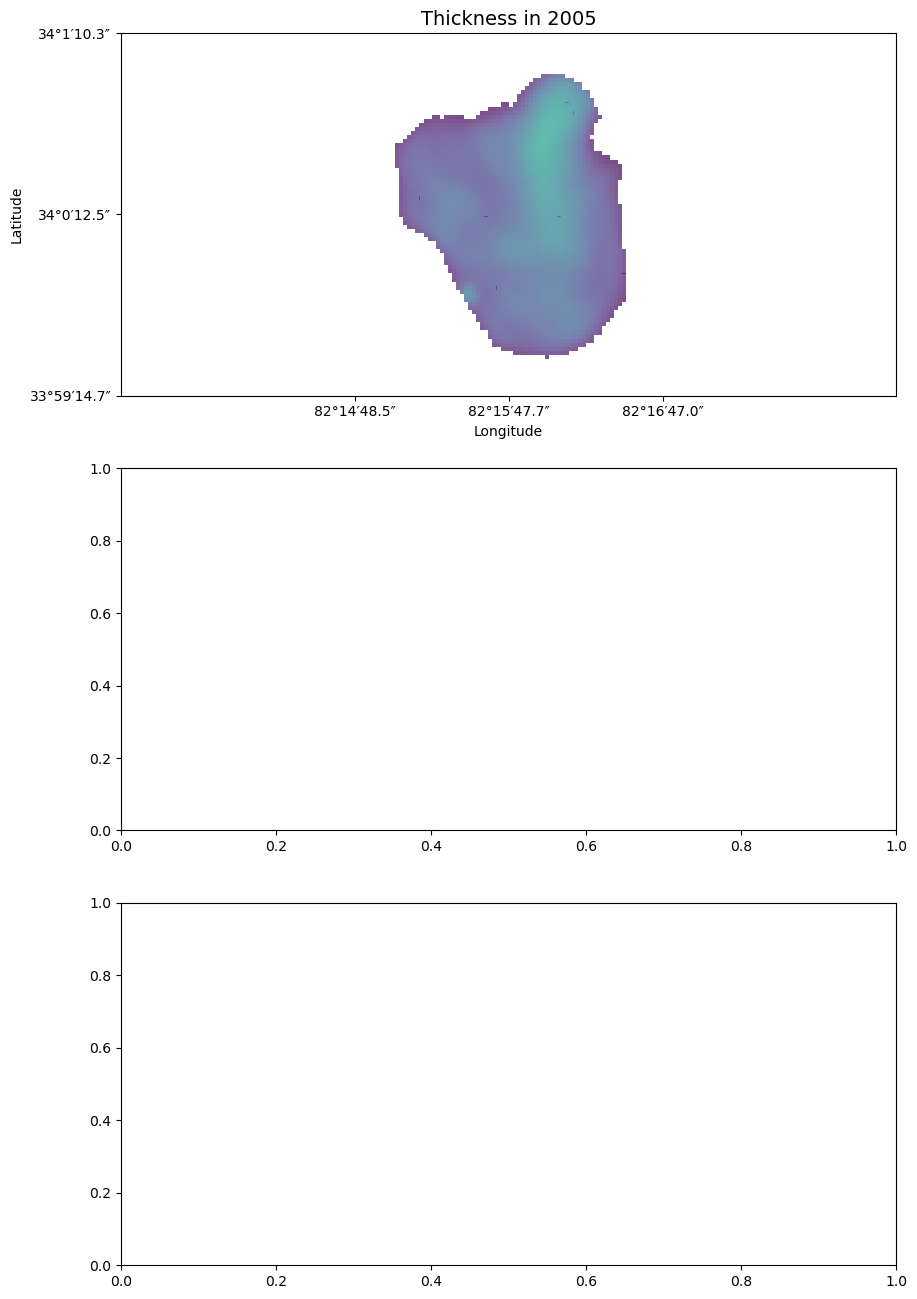

In [18]:
def plot_distributed_thickness_with_basemap(ds, title):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import numpy as np
    import pyproj
    import contextily as ctx

    def get_grid_edges(arr):
        edges = (arr[:-1] + arr[1:]) / 2
        edges = np.concatenate(([arr[0] - (edges[0] - arr[0])], edges, [arr[-1] + (arr[-1] - edges[-1])]))
        return edges

    def deg2dms(x, pos):
        degrees = int(x)
        minutes = int(abs(x - degrees) * 60)
        seconds = (abs(x - degrees) * 60 - minutes) * 60
        return f"{degrees}°{minutes}′{seconds:.1f}″"

    # 原始中心坐标
    x = ds.coords['x'].values
    y = ds.coords['y'].values

    # 获取边界点（适用于pcolormesh）
    x_edges = get_grid_edges(x)
    y_edges = get_grid_edges(y)
    xx_edges, yy_edges = np.meshgrid(x_edges, y_edges)

    # 坐标变换器：原始 → Web Mercator（用于底图）
    proj = pyproj.CRS.from_string(ds.attrs['pyproj_srs'])
    web_mercator = pyproj.CRS.from_epsg(3857)
    transformer_to_wm = pyproj.Transformer.from_crs(proj, web_mercator, always_xy=True)
    wm_x, wm_y = transformer_to_wm.transform(xx_edges, yy_edges)

    # 再从 Web Mercator → 经纬度（用于坐标刻度标签）
    transformer_to_wgs84 = pyproj.Transformer.from_crs(web_mercator, 4326, always_xy=True)
    lon, lat = transformer_to_wgs84.transform(wm_x, wm_y)

    fig, axes = plt.subplots(3, 1, figsize=(10, 16))
    times = [2005, 2050, 2100]

    for i, t in enumerate(times):
        ax = axes[i]

        

        # 厚度图层
        im = ax.pcolormesh(wm_x, wm_y,
                           ds.simulated_thickness.sel(time=t),
                           shading='auto', cmap='viridis', vmax=150, alpha=0.7)

        # 设置坐标轴范围
        ax.set_xlim(wm_x.min(), wm_x.max())
        ax.set_ylim(wm_y.min(), wm_y.max())
        ax.set_title(f"Thickness in {t}", fontsize=14)
        ax.axis('equal')

        # 设置坐标刻度为经纬度
        xticks = np.linspace(wm_x.min(), wm_x.max(), 3)
        yticks = np.linspace(wm_y.min(), wm_y.max(), 3)
        lon_ticks, lat_ticks = transformer_to_wgs84.transform(xticks, yticks)

        ax.set_xticks(xticks)
        ax.set_yticks(yticks)

        ax.xaxis.set_major_formatter(mticker.FuncFormatter(
            lambda x, pos: deg2dms(transformer_to_wgs84.transform(x, wm_y.mean())[0], pos)))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(
            lambda y, pos: deg2dms(transformer_to_wgs84.transform(wm_x.mean(), y)[1], pos)))

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
# 显示底图
        ctx.add_basemap(ax, crs=web_mercator, source="OpenTopoMap", zoom=10)
        fig.colorbar(im, ax=ax, orientation='vertical', label='Thickness (m)')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_distributed_thickness_with_basemap(ds[0], 'Aru50 Thickness with Basemap')

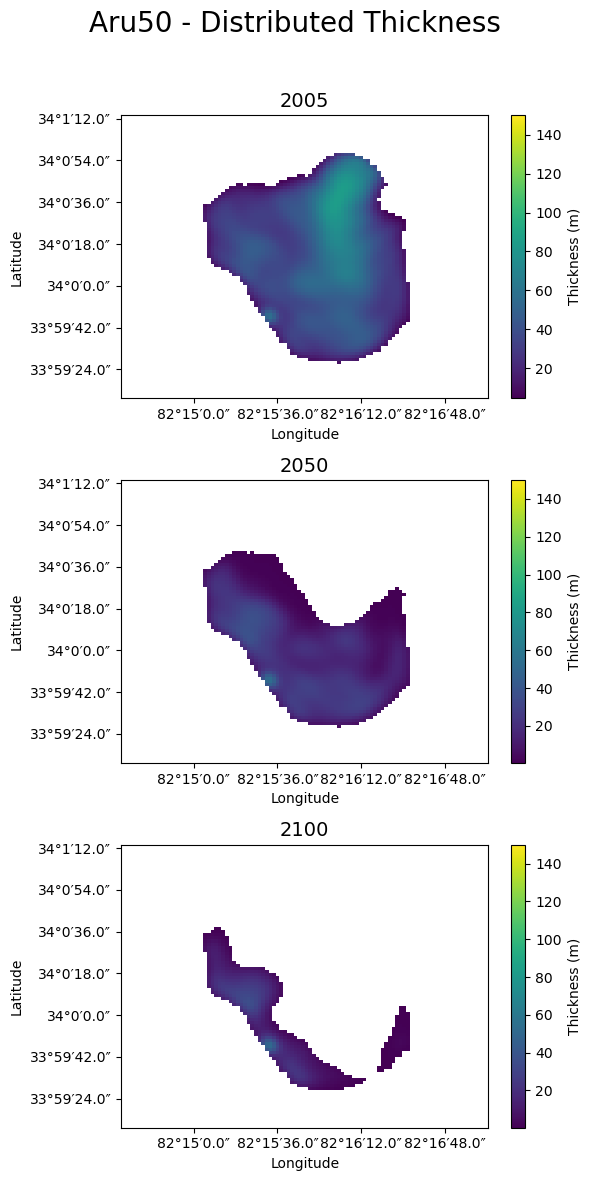

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pyproj

def deg2dms(x, pos):
    degrees = int(x)
    minutes = int(abs(x - degrees) * 60)
    seconds = (abs(x - degrees) * 60 - minutes) * 60
    return f"{degrees}°{minutes}′{seconds:.1f}″"

def plot_distributed_thickness_vertical(ds, title):
    x = ds.coords['x'].values
    y = ds.coords['y'].values
    xx, yy = np.meshgrid(x, y)

    # 投影转换：从投影坐标到经纬度
    proj = pyproj.CRS.from_string(ds.attrs['pyproj_srs'])
    wgs84 = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(proj, wgs84, always_xy=True)
    lon, lat = transformer.transform(xx, yy)

    # 创建 3 个纵向图
    fig, axes = plt.subplots(3, 1, figsize=(6, 12))  # 3 行 1 列
    times = [2005, 2050, 2100]

    for i, t in enumerate(times):
        im = axes[i].pcolormesh(lon, lat, ds.simulated_thickness.sel(time=t),
                                shading='auto', cmap='viridis', vmax=150)
        axes[i].set_title(f"{t}", fontsize=14)
        axes[i].axis('equal')
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(deg2dms))
        axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(deg2dms))
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[i], orientation='vertical', label='Thickness (m)')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 留出标题空间
    plt.show()

# 使用方法
plot_distributed_thickness_vertical(ds[0], 'Aru50 - Distributed Thickness')


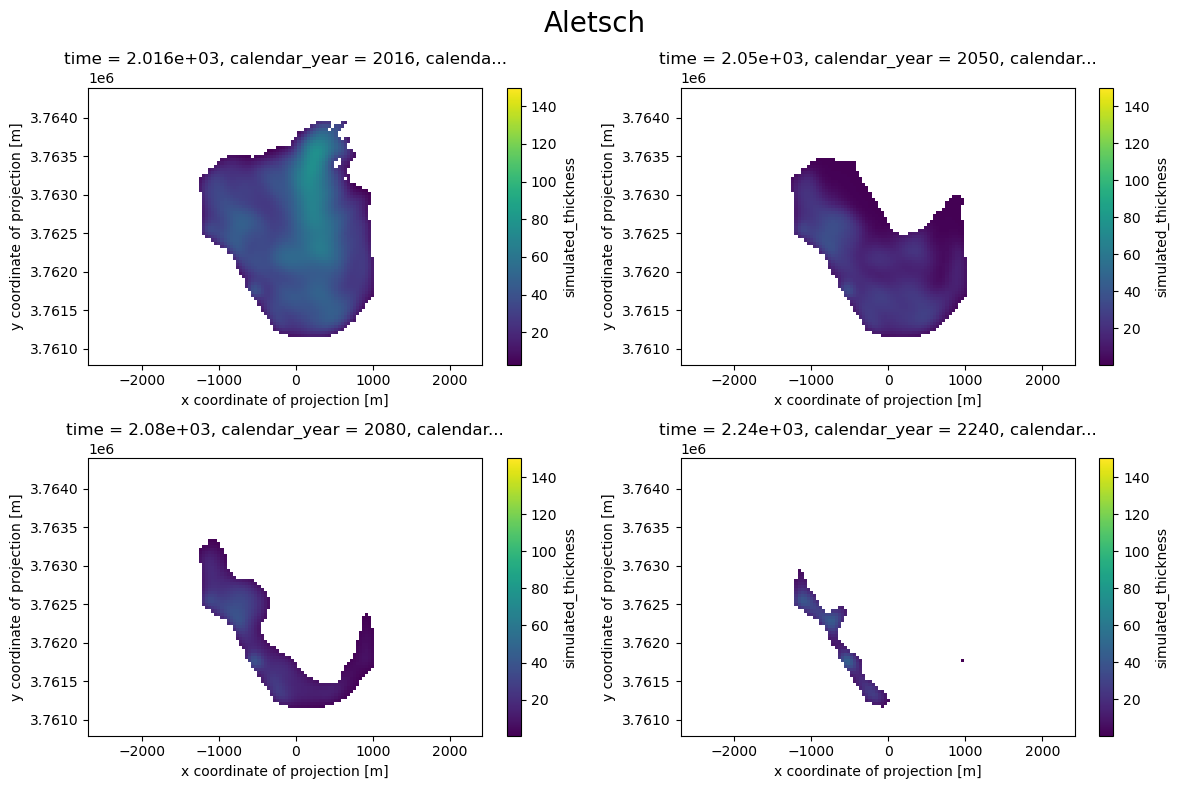

In [ ]:
def plot_distributed_thickness(ds, title):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2行2列
    # 第一行两个图
    ds.simulated_thickness.sel(time=2016).plot(ax=axes[0, 0], vmax=150)
    ds.simulated_thickness.sel(time=2050).plot(ax=axes[0, 1], vmax=150)
    # 第二行第一个图，第二个空白
    ds.simulated_thickness.sel(time=2080).plot(ax=axes[1, 0], vmax=150)
    # ds.simulated_thickness.sel(time=2100).plot(ax=axes[1, 0], vmax=150)
    ds.simulated_thickness.sel(time=2240).plot(ax=axes[1, 1], vmax=150)
    # 隐藏右下角空图
    # axes[1, 1].axis('off')

    for ax in axes.flatten():
        ax.axis('equal')
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()
    

plot_distributed_thickness(ds[0], 'Aletsch')


✅ 图像已保存为 EPS 文件：/mnt/d/lidar/ali/area/same_boundary/thickness_plot.eps


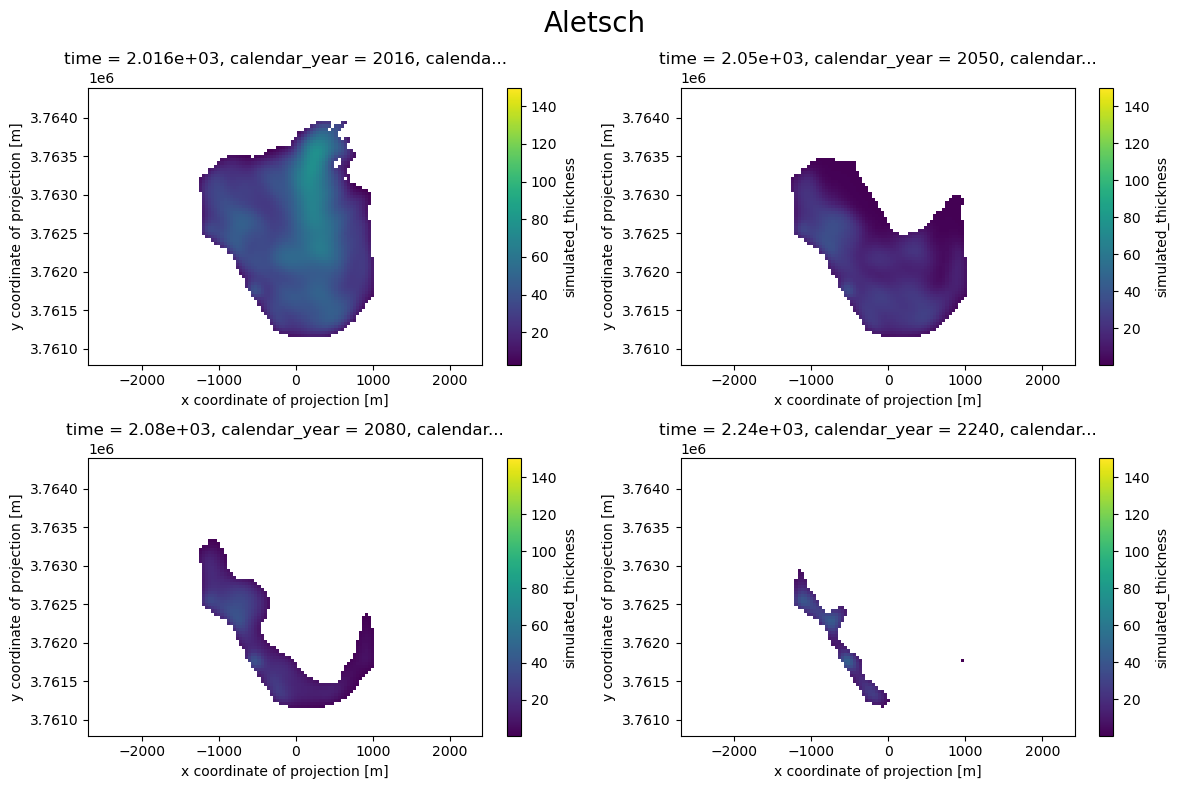

In [28]:
def plot_distributed_thickness(ds, title, filename='thickness_plot.eps'):
    import matplotlib.pyplot as plt
    import os
    from oggm import cfg

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2行2列

    # 第一行两个图
    ds.simulated_thickness.sel(time=2016).plot(ax=axes[0, 0], vmax=150)
    ds.simulated_thickness.sel(time=2050).plot(ax=axes[0, 1], vmax=150)

    # 第二行两个图
    ds.simulated_thickness.sel(time=2080).plot(ax=axes[1, 0], vmax=150)
    ds.simulated_thickness.sel(time=2240).plot(ax=axes[1, 1], vmax=150)

    for ax in axes.flatten():
        ax.axis('equal')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()

    # 构建保存路径
    save_path = os.path.join(cfg.PATHS['working_dir'], filename)

    # 保存为 EPS 文件
    plt.savefig(save_path, format='eps', dpi=300)
    print(f'✅ 图像已保存为 EPS 文件：{save_path}')

    plt.show()

plot_distributed_thickness(ds[0], 'Aletsch')

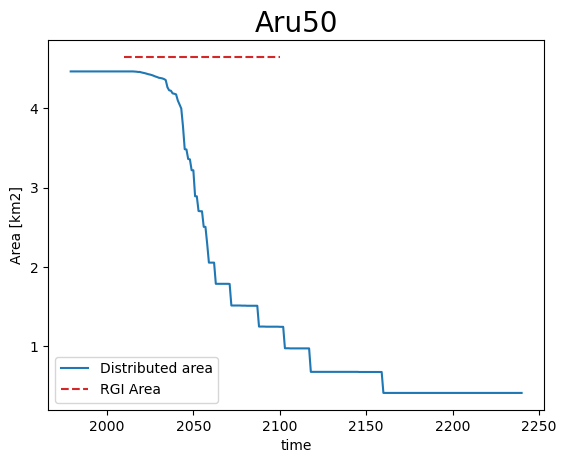

In [54]:
def plot_area(ds, gdir, title):
    area = (ds.simulated_thickness > 0).sum(dim=['x', 'y']) * gdir.grid.dx**2 * 1e-6
    area.plot(label='Distributed area');
    plt.hlines(gdir.rgi_area_km2, gdir.rgi_date, 2100, color='C3', linestyles='--', label='RGI Area');
    plt.legend(loc='lower left'); plt.ylabel('Area [km2]'); plt.title(title, fontsize=20); plt.show();


plot_area(ds[0], gdirs[0], 'Aru50')
# plot_area(ds[1], gdirs[1], 'Fieschergletscher')

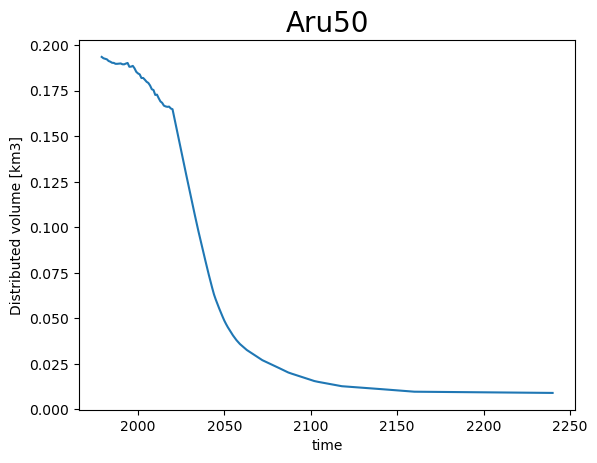

In [55]:
def plot_volume(ds, gdir, title):
    vol = ds.simulated_thickness.sum(dim=['x', 'y']) * gdir.grid.dx**2 * 1e-9
    vol.plot(label='Distributed volume'); plt.ylabel('Distributed volume [km3]');
    plt.title(title, fontsize=20); plt.show();


plot_volume(ds[0], gdirs[0], 'Aru50')
# plot_volume(ds[1], gdirs[1], 'Fieschergletscher')

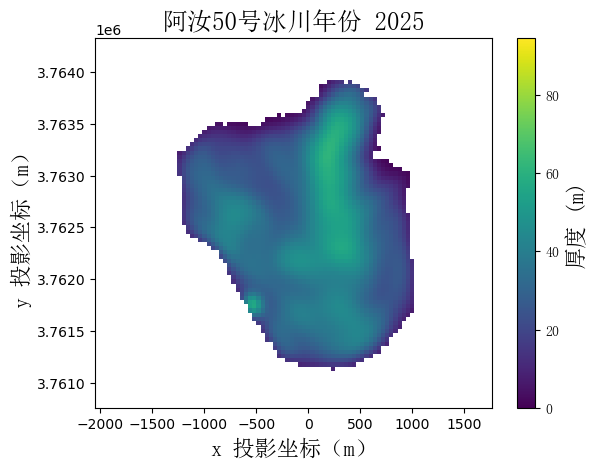

In [20]:
from matplotlib import animation
from IPython.display import HTML, display
from matplotlib import font_manager as fm
font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

fig, ax = plt.subplots()
thk = ds[0]['simulated_thickness']

# 初始化绘图（注意 add_colorbar=False）
im = thk.isel(time=0).plot(
    ax=ax,
    add_colorbar=False,
    cmap='viridis',
    vmin=0, vmax=thk.max()
)
ax.axis('equal')

# 单独创建 colorbar，并设置中文字体
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='厚度 (m)')
cbar.set_label('厚度 (m)', fontproperties=my_font,fontsize=16)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(my_font)

def animate(frame):
    ax.set_title(f'阿汝50号冰川年份 {int(thk.time[frame])}', fontproperties=my_font, fontsize=18)
    ax.set_ylabel('y 投影坐标（m）', fontproperties=my_font, fontsize=16)
    ax.set_xlabel('x 投影坐标（m）', fontproperties=my_font, fontsize=16)
    im.set_array(thk.values[frame, :].flatten())  # 更新数据
# 假设 thk.time 是年份数组或者可转换为年份
years = thk.time.values.astype(int)  # 转换为整数年份

# 找到起止索引
start_idx = int(np.where(years >= 2025)[0][0])
end_idx = int(np.where(years <= 2100)[0][-1])

# 创建动画，只包含指定年份
ani_glacier = animation.FuncAnimation(
    fig, 
    animate, 
    frames=range(start_idx, end_idx + 1), 
    interval=100
)


# ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=100)


In [21]:
HTML(ani_glacier.to_jshtml())

In [22]:
from matplotlib import animation
from IPython.display import HTML
import numpy as np

# 假设已有 fig, ax, im, animate 函数定义
ani_glacier = animation.FuncAnimation(
    fig, animate, frames=range(start_idx, len(thk.time)), interval=100
)

# 保存为 GIF
ani_glacier.save('/mnt/d/lidar/ali/area/same_boundary/Aru50_glacier.gif', writer='pillow', fps=10)
